In [1]:
from pathlib import Path
import sys

scriptPath = Path(sys.path[0])
parentPath = scriptPath.parent
dataPath = parentPath / 'data'
srcPath = parentPath / 'src'
modelPath = parentPath / 'models'
plotPath = parentPath / 'plots'
miscPath = parentPath / 'misc'

sys.path.append(srcPath.as_posix())

In [2]:
import torch
from torchvision import datasets, transforms

batch_size = 128
image_size = 28

""" Prepare data loaders """
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataPath, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize(image_size),
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dataPath, train=False, transform=transforms.Compose([
                       transforms.Resize(image_size),
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from torch.cuda.amp import autocast
import torch.nn.functional as F

# Training procedure
def train(epoch):

    slope = 1.

    print('\n# Epoch : {} - Slope : {}'.format(epoch, slope))

    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        with autocast():
            output = model(data)
            loss = F.nll_loss(output, target)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        loss.backward()
        optimizer.step()
        train_loss += loss.data

    train_loss /= len(train_loader)
    train_loss = train_loss.item()
    train_acc = correct / len(train_loader.dataset)

    print(f'Training Loss : {train_loss}, training accuracy : {int(correct)}/{len(train_loader.dataset)} ({train_acc*100:.3f}%)')

    return train_loss, train_acc

# Testing procedure
def test(epoch, best_acc):
    slope = 1.

    model.eval()
    test_loss = 0.0
    correct = 0.0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target).data.item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)
    print(f'Test set: average loss: {test_loss:.4f}, accuracy: {int(correct)}/{len(test_loader.dataset)} ({100. * test_acc:.3f}%)')

    return test_loss, test_acc

In [5]:
torch.set_num_threads(1) 

In [6]:
from SPDNN_Conv import PDConvNet

n_linear = 400
n_chan = [16]
stride = [1]
kernel_size = [5]
anneal_factor = 1.000

model = PDConvNet(d_input=(1,image_size,image_size),n_linear=n_linear,n_output=10,\
                  n_chan=n_chan,kss=kernel_size,ss=stride,batchnorm=False).to(device)

lr = 0.01
momentum = 0.9
num_epoch = 300
optimizer = torch.optim.SGD(model.parameters(),lr=lr, momentum=momentum)

model_name = f"MNIST{image_size}x{image_size}_conv{n_chan}_ks{kernel_size}_s{stride}_N{n_linear}_batch{batch_size}_SGD_lr{lr}_mom{momentum}"

acc_track = []
train_acc_track = []
best_acc = 0.
print(model_name)
model

MNIST28x28_conv[16]_ks[5]_s[1]_N400_batch128_SGD_lr0.01_mom0.9


PDConvNet(
  (convs): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): PhotonActivationCoh(
      (act): PhotonCountingP()
    )
    (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=400, bias=False)
  (linear_act): PhotonActivationCoh(
    (act): PhotonCountingP()
  )
  (fc2): Linear(in_features=400, out_features=10, bias=True)
)

In [7]:
%%time
acc_track = []
train_acc_track = []
for epoch in range(1, num_epoch + 1):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch, best_acc)
    best_acc = max(test_acc, best_acc)
    print(f'Best test accuracy so far: {best_acc*100:.3f}%')
    acc_track.append(test_acc)
    train_acc_track.append(train_acc)

# Epoch : 1 - Slope : 1.0
Training Loss : 0.9554390907287598, training accuracy : 41647/60000 (69.412%)
Test set: average loss: 0.0022, accuracy: 9148/10000 (91.480%)
Best test accuracy so far: 91.480%
# Epoch : 2 - Slope : 1.0
Training Loss : 0.22356373071670532, training accuracy : 55948/60000 (93.247%)
Test set: average loss: 0.0013, accuracy: 9517/10000 (95.170%)
Best test accuracy so far: 95.170%
# Epoch : 3 - Slope : 1.0
Training Loss : 0.14806203544139862, training accuracy : 57280/60000 (95.467%)
Test set: average loss: 0.0010, accuracy: 9612/10000 (96.120%)
Best test accuracy so far: 96.120%
# Epoch : 4 - Slope : 1.0
Training Loss : 0.11315246671438217, training accuracy : 57929/60000 (96.548%)
Test set: average loss: 0.0008, accuracy: 9701/10000 (97.010%)
Best test accuracy so far: 97.010%
# Epoch : 5 - Slope : 1.0
Training Loss : 0.09302394092082977, training accuracy : 58259/60000 (97.098%)
Test set: average loss: 0.0008, accuracy: 9697/10000 (96.970%)
Best test accuracy so

Training Loss : 0.013712727464735508, training accuracy : 59750/60000 (99.583%)
Test set: average loss: 0.0003, accuracy: 9862/10000 (98.620%)
Best test accuracy so far: 98.860%
# Epoch : 42 - Slope : 1.0
Training Loss : 0.013551495969295502, training accuracy : 59748/60000 (99.580%)
Test set: average loss: 0.0003, accuracy: 9888/10000 (98.880%)
Best test accuracy so far: 98.880%
# Epoch : 43 - Slope : 1.0
Training Loss : 0.01333883311599493, training accuracy : 59754/60000 (99.590%)
Test set: average loss: 0.0003, accuracy: 9864/10000 (98.640%)
Best test accuracy so far: 98.880%
# Epoch : 44 - Slope : 1.0
Training Loss : 0.012342890724539757, training accuracy : 59774/60000 (99.623%)
Test set: average loss: 0.0003, accuracy: 9862/10000 (98.620%)
Best test accuracy so far: 98.880%
# Epoch : 45 - Slope : 1.0
Training Loss : 0.011940838769078255, training accuracy : 59774/60000 (99.623%)
Test set: average loss: 0.0003, accuracy: 9870/10000 (98.700%)
Best test accuracy so far: 98.880%
# E

Training Loss : 0.006618469022214413, training accuracy : 59878/60000 (99.797%)
Test set: average loss: 0.0003, accuracy: 9884/10000 (98.840%)
Best test accuracy so far: 99.040%
# Epoch : 82 - Slope : 1.0
Training Loss : 0.006136548239737749, training accuracy : 59903/60000 (99.838%)
Test set: average loss: 0.0003, accuracy: 9889/10000 (98.890%)
Best test accuracy so far: 99.040%
# Epoch : 83 - Slope : 1.0
Training Loss : 0.006174628157168627, training accuracy : 59900/60000 (99.833%)
Test set: average loss: 0.0003, accuracy: 9887/10000 (98.870%)
Best test accuracy so far: 99.040%
# Epoch : 84 - Slope : 1.0
Training Loss : 0.006086935754865408, training accuracy : 59890/60000 (99.817%)
Test set: average loss: 0.0003, accuracy: 9887/10000 (98.870%)
Best test accuracy so far: 99.040%
# Epoch : 85 - Slope : 1.0
Training Loss : 0.005476600024849176, training accuracy : 59918/60000 (99.863%)
Test set: average loss: 0.0003, accuracy: 9894/10000 (98.940%)
Best test accuracy so far: 99.040%
# 

Training Loss : 0.00299362326040864, training accuracy : 59953/60000 (99.922%)
Test set: average loss: 0.0003, accuracy: 9895/10000 (98.950%)
Best test accuracy so far: 99.040%
# Epoch : 122 - Slope : 1.0
Training Loss : 0.004174020141363144, training accuracy : 59926/60000 (99.877%)
Test set: average loss: 0.0003, accuracy: 9897/10000 (98.970%)
Best test accuracy so far: 99.040%
# Epoch : 123 - Slope : 1.0
Training Loss : 0.003615115536376834, training accuracy : 59947/60000 (99.912%)
Test set: average loss: 0.0003, accuracy: 9894/10000 (98.940%)
Best test accuracy so far: 99.040%
# Epoch : 124 - Slope : 1.0
Training Loss : 0.003632620209828019, training accuracy : 59930/60000 (99.883%)
Test set: average loss: 0.0003, accuracy: 9884/10000 (98.840%)
Best test accuracy so far: 99.040%
# Epoch : 125 - Slope : 1.0
Training Loss : 0.0032775860745459795, training accuracy : 59948/60000 (99.913%)
Test set: average loss: 0.0003, accuracy: 9881/10000 (98.810%)
Best test accuracy so far: 99.040

Training Loss : 0.0025284974835813046, training accuracy : 59961/60000 (99.935%)
Test set: average loss: 0.0003, accuracy: 9893/10000 (98.930%)
Best test accuracy so far: 99.040%
# Epoch : 162 - Slope : 1.0
Training Loss : 0.0024670460261404514, training accuracy : 59967/60000 (99.945%)
Test set: average loss: 0.0003, accuracy: 9893/10000 (98.930%)
Best test accuracy so far: 99.040%
# Epoch : 163 - Slope : 1.0
Training Loss : 0.002496326807886362, training accuracy : 59958/60000 (99.930%)
Test set: average loss: 0.0003, accuracy: 9891/10000 (98.910%)
Best test accuracy so far: 99.040%
# Epoch : 164 - Slope : 1.0
Training Loss : 0.0024232061114162207, training accuracy : 59964/60000 (99.940%)
Test set: average loss: 0.0003, accuracy: 9891/10000 (98.910%)
Best test accuracy so far: 99.040%
# Epoch : 165 - Slope : 1.0
Training Loss : 0.0025578374043107033, training accuracy : 59961/60000 (99.935%)
Test set: average loss: 0.0003, accuracy: 9890/10000 (98.900%)
Best test accuracy so far: 99

Training Loss : 0.001637464971281588, training accuracy : 59975/60000 (99.958%)
Test set: average loss: 0.0003, accuracy: 9886/10000 (98.860%)
Best test accuracy so far: 99.040%
# Epoch : 202 - Slope : 1.0
Training Loss : 0.0016346026677638292, training accuracy : 59978/60000 (99.963%)
Test set: average loss: 0.0003, accuracy: 9889/10000 (98.890%)
Best test accuracy so far: 99.040%
# Epoch : 203 - Slope : 1.0
Training Loss : 0.002083742758259177, training accuracy : 59966/60000 (99.943%)
Test set: average loss: 0.0003, accuracy: 9892/10000 (98.920%)
Best test accuracy so far: 99.040%
# Epoch : 204 - Slope : 1.0
Training Loss : 0.0016548236599192023, training accuracy : 59975/60000 (99.958%)
Test set: average loss: 0.0003, accuracy: 9900/10000 (99.000%)
Best test accuracy so far: 99.040%
# Epoch : 205 - Slope : 1.0
Training Loss : 0.0019679677207022905, training accuracy : 59973/60000 (99.955%)
Test set: average loss: 0.0003, accuracy: 9896/10000 (98.960%)
Best test accuracy so far: 99.

Training Loss : 0.0015258300118148327, training accuracy : 59981/60000 (99.968%)
Test set: average loss: 0.0003, accuracy: 9878/10000 (98.780%)
Best test accuracy so far: 99.110%
# Epoch : 242 - Slope : 1.0
Training Loss : 0.0015887330519035459, training accuracy : 59978/60000 (99.963%)
Test set: average loss: 0.0003, accuracy: 9896/10000 (98.960%)
Best test accuracy so far: 99.110%
# Epoch : 243 - Slope : 1.0
Training Loss : 0.0015082837780937552, training accuracy : 59984/60000 (99.973%)
Test set: average loss: 0.0003, accuracy: 9888/10000 (98.880%)
Best test accuracy so far: 99.110%
# Epoch : 244 - Slope : 1.0
Training Loss : 0.0017640895675867796, training accuracy : 59973/60000 (99.955%)
Test set: average loss: 0.0003, accuracy: 9886/10000 (98.860%)
Best test accuracy so far: 99.110%
# Epoch : 245 - Slope : 1.0
Training Loss : 0.0014024617848917842, training accuracy : 59978/60000 (99.963%)
Test set: average loss: 0.0003, accuracy: 9890/10000 (98.900%)
Best test accuracy so far: 9

Training Loss : 0.0014063763665035367, training accuracy : 59975/60000 (99.958%)
Test set: average loss: 0.0003, accuracy: 9892/10000 (98.920%)
Best test accuracy so far: 99.120%
# Epoch : 282 - Slope : 1.0
Training Loss : 0.0009800591506063938, training accuracy : 59991/60000 (99.985%)
Test set: average loss: 0.0003, accuracy: 9876/10000 (98.760%)
Best test accuracy so far: 99.120%
# Epoch : 283 - Slope : 1.0
Training Loss : 0.0013640933902934194, training accuracy : 59979/60000 (99.965%)
Test set: average loss: 0.0003, accuracy: 9901/10000 (99.010%)
Best test accuracy so far: 99.120%
# Epoch : 284 - Slope : 1.0
Training Loss : 0.0011993251973763108, training accuracy : 59983/60000 (99.972%)
Test set: average loss: 0.0003, accuracy: 9895/10000 (98.950%)
Best test accuracy so far: 99.120%
# Epoch : 285 - Slope : 1.0
Training Loss : 0.0012198301265016198, training accuracy : 59984/60000 (99.973%)
Test set: average loss: 0.0003, accuracy: 9885/10000 (98.850%)
Best test accuracy so far: 9

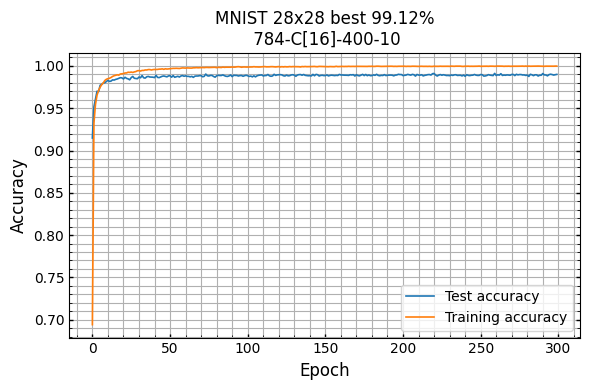

In [12]:
import matplotlib.pyplot as plt
plt.style.use(miscPath / 'plot.mplstyle')

fig, ax = plt.subplots(dpi=100)
plt.plot(acc_track, label='Test accuracy')
plt.plot(train_acc_track, label='Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"MNIST {image_size}x{image_size} best {best_acc*100:.4g}%\n 784-C{n_chan}-{n_linear}-10")
plt.legend()
plt.minorticks_on()
plt.grid(which='both')
plt.tight_layout()
plt.savefig(plotPath / f'{model_name}.png')

In [9]:
torch.save(model.state_dict(), modelPath / f'{model_name}.pth')